<a href="https://colab.research.google.com/github/charu13a/knowledge-games/blob/word2vec/sudoku.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook attempts to use Convolutional Neural Network to classify a sudoku as valid or invalid. Only fully filled sudokus are supported.

# Sudoku Classification using CNN

## Setup

Import necessary modules.

In [1]:
import copy
import csv
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Conv2D, Concatenate, GaussianNoise
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import numpy as np
import os
import random
from random import randrange
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

Using TensorFlow backend.


Seed the network to get reproducible results

In [0]:
from numpy.random import seed
seed(2)
from tensorflow import set_random_seed
set_random_seed(2)

  Setup kaggle API as we will be using a kaggle dataset for the sudokus.

In [4]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"charu13a","key":"ef0f9dcd4c5b32ac36041509a729c421"}'}

Install kaggle API.

In [0]:
!pip install -q kaggle

Move the kaggle.json file into ~/.kaggle, which is where the API client expects your token to be located

In [0]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

## Download and read filled sudokus.

In [7]:
!kaggle datasets download -d bryanpark/sudoku

 95% 65.0M/68.1M [00:00<00:00, 84.3MB/s]
100% 68.1M/68.1M [00:00<00:00, 87.6MB/s]


In [8]:
!unzip sudoku.zip

Archive:  sudoku.zip
  inflating: sudoku.csv              


In [9]:
!head sudoku.csv

quizzes,solutions
004300209005009001070060043006002087190007400050083000600000105003508690042910300,864371259325849761971265843436192587198657432257483916689734125713528694542916378
040100050107003960520008000000000017000906800803050620090060543600080700250097100,346179258187523964529648371965832417472916835813754629798261543631485792254397186
600120384008459072000006005000264030070080006940003000310000050089700000502000190,695127384138459672724836915851264739273981546946573821317692458489715263562348197
497200000100400005000016098620300040300900000001072600002005870000600004530097061,497258316186439725253716498629381547375964182841572639962145873718623954534897261
005910308009403060027500100030000201000820007006007004000080000640150700890000420,465912378189473562327568149738645291954821637216397854573284916642159783891736425
100005007380900000600000480820001075040760020069002001005039004000020100000046352,19468523738297451665721348982349167554176892376935284121583976443652719897814635

Read csv file.

In [0]:
SUDOKU_FILE = '/content/sudoku.csv'

In [0]:
sudoku = []
# reading csv file 
with open(SUDOKU_FILE, 'r') as csvfile: 
    data = csv.reader(csvfile)
    next(data, None)  # skip the headers
    for row in data:
        sudoku.append(row[1])

sudoku = list(map(lambda x: [int(i)/10 for i in str(x)], sudoku))

## Create invalid sudokus and label them.

copy the sudokus into valid and invalid.

In [0]:
valid = copy.deepcopy(sudoku)
invalid = copy.deepcopy(sudoku)

def makeInvalid(s):
    for i in range(81):
        random_index = randrange(len(s))
        diff = (randrange(8) + 1) / 10
        s[random_index] = (s[random_index]+diff)%1
    return s

# make invalid sudoku
invalid = list(map(lambda s: makeInvalid(s), invalid))

Add labels to sudoku

In [0]:
labelled_sudoku = []

for x in invalid:
    labelled_sudoku.append([x, 0])
for x in valid:
    labelled_sudoku.append([x, 1])

Split test and train data.

In [0]:
random.shuffle(labelled_sudoku)
# split labels and sudoku
X = []
Y = []

for x in labelled_sudoku:
    X.append(x[0])
    Y.append(x[1])

Y = to_categorical(Y, 2)

X = np.array(X)
Y = np.array(Y)

X = X.reshape(len(X), 9, 9, 1)
input_shape = (9, 9, 1)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1)

## Defining the model.

### Define the model layers.

In [0]:
# Conv2D to calculate each block sum
model_block_sum = Sequential()
model_block_sum.add(Conv2D(1, kernel_size=(3, 3),
                 activation='relu',
                 strides=3,
                 input_shape=input_shape))
model_block_sum.add(Flatten())

# Conv2D to calculate each column sum
model_col_sum = Sequential()
model_col_sum.add(Conv2D(1, kernel_size=(1, 9),
                 activation='relu',
                 input_shape=input_shape))
model_col_sum.add(Flatten())

# Conv2D to calculate each row sum
model_row_sum = Sequential()
model_row_sum.add(Conv2D(1, kernel_size=(9, 1),
                 activation='relu',
                 input_shape=input_shape))
model_row_sum.add(Flatten())

conc = Concatenate()([model_block_sum.output, model_row_sum.output, model_col_sum.output])
out = GaussianNoise(0.01)(conc)
out = Dense(32, activation='relu')(out)
out = Dense(32, activation='relu')(out)
out = Dense(len(Y[0]), activation='softmax')(out)

model = Model([model_block_sum.input, model_row_sum.input, model_col_sum.input], out)

### Train the model.

In [28]:
model.compile(loss='categorical_crossentropy', optimizer='nadam', metrics=['accuracy']) # compile the model
model_log=model.fit([X_train]*3, y_train, epochs=10, batch_size=32, validation_split=0.10,
    callbacks=[EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=1,
                              verbose=0, mode='auto'), 
               ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]) 

Train on 1620000 samples, validate on 180000 samples
Epoch 1/10
1620000/1620000 [==============================] - 94s 58us/step - loss: 0.0100 - acc: 0.9965 - val_loss: 5.6582e-06 - val_acc: 1.0000
Epoch 2/10
1620000/1620000 [==============================] - 95s 58us/step - loss: 7.7066e-05 - acc: 1.0000 - val_loss: 1.3148e-04 - val_acc: 1.0000


### Evaluate the model.

In [29]:
score = model.evaluate([X_test]*3, y_test, verbose=1)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

# predict probabilities for test set
yhat_probs = model.predict([X_test]*3, verbose=1)
# predict crisp classes for test set
yhat_classes = np.argmax(yhat_probs, axis=1)

# reduce to 1d array
yhat_probs = [row[1] for row in yhat_probs]
yhat_test = [row[1] for row in y_test]

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(yhat_test, yhat_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(yhat_test, yhat_classes)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(yhat_test, yhat_classes)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(yhat_test, yhat_classes)
print('F1 score: %f' % f1)

# kappa
kappa = cohen_kappa_score(yhat_test, yhat_classes)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(yhat_test, yhat_probs)
print('ROC AUC: %f' % auc)
# confusion matrix
matrix = confusion_matrix(yhat_test, yhat_classes)
print(matrix)

model.summary()

200000/200000 [==============================] - 5s 24us/step
Test loss: 9.539856466777564e-05
Test accuracy: 0.999945
200000/200000 [==============================] - 4s 20us/step
Accuracy: 0.999945
Precision: 0.999890
Recall: 1.000000
F1 score: 0.999945
Cohens kappa: 0.999890
ROC AUC: 1.000000
[[ 99938     11]
 [     0 100051]]
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
conv2d_4_input (InputLayer)     (None, 9, 9, 1)      0                                            
__________________________________________________________________________________________________
conv2d_6_input (InputLayer)     (None, 9, 9, 1)      0                                            
__________________________________________________________________________________________________
conv2d_5_input (InputLayer)     (None, 9, 9, 1)      0   

Plot the filters.

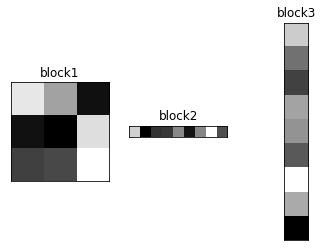

In [31]:
fig,ax = plt.subplots(nrows=1,ncols=3)
for i in range(3):
    weights = model.get_layer('conv2d_'+str((i+4))).get_weights()
    ax[i].imshow(weights[0][:,:,:,0][:,:,0],cmap='gray')
    ax[i].set_title('block'+str(i+1))
    ax[i].set_xticks([])
    ax[i].set_yticks([])

Let us see what weights are learnt.

In [32]:
from pprint import pprint

for i in range(3):
  pprint(model.get_layer('conv2d_'+str((i+4))).get_weights())

[array([[[[ 0.19375688]],

        [[-0.21937901]],

        [[-1.0906626 ]]],


       [[[-1.0861107 ]],

        [[-1.1900456 ]],

        [[ 0.14236784]]],


       [[[-0.8058033 ]],

        [[-0.7586414 ]],

        [[ 0.34258527]]]], dtype=float32),
 array([0.34523037], dtype=float32)]
[array([[[[-0.28395736]],

        [[-0.32165506]],

        [[-0.31230453]],

        [[-0.3113845 ]],

        [[-0.2967655 ]],

        [[-0.3179535 ]],

        [[-0.29713365]],

        [[-0.2754294 ]],

        [[-0.3073476 ]]]], dtype=float32),
 array([1.0785292], dtype=float32)]
[array([[[[0.8814502 ]]],


       [[[0.8535398 ]]],


       [[[0.83851296]]],


       [[[0.86928165]]],


       [[[0.86383927]]],


       [[[0.84629864]]],


       [[[0.897563  ]]],


       [[[0.87093246]]],


       [[[0.8181873 ]]]], dtype=float32),
 array([-3.4767084], dtype=float32)]


## Predicting using the trained model.

Let's define a method that will predict if the sudoku is valid or invalid.

In [0]:
def predict(test_sudoku, model):
  test_sudoku = [int(i)/10 for i in str(test_sudoku)]

  test_sudoku = np.array([test_sudoku])
  test_sudoku = test_sudoku.reshape(1, 9, 9, 1)

  prediction = model.predict([test_sudoku]*3)
  return np.argmax(prediction[0])

In [34]:
s = 563472198219386754847195623472638519951247386638519472795864231324951867186723945 # valid sudoku
s_1 = 163472198219386754847195623472638519951247386638519472795864231324951867186723945 # sudoku with one error
s_2 = 742951847814672953759348126391725684476189532285436791548217369927863415163594278 # sudoku with two random errors
s_3 = 257468293138971645469532781926153478741896532583724916674385129892617354315249867 # sudoku with two errors such that net sum is zero
print("Expected: 1, Predicted:", predict(s, model))
print("Expected: 0, Predicted:", predict(s_1, model))
print("Expected: 0, Predicted:", predict(s_2, model))
print("Expected: 0, Predicted:", predict(s_3, model))

Expected: 1, Predicted: 1
Expected: 0, Predicted: 0
Expected: 0, Predicted: 1
Expected: 0, Predicted: 1


## Visualizing the data

### Principal Component Analysis (PCA)

Let us understand our data by visualizing it using PCA.

In [35]:
from sklearn.decomposition import PCA 
import seaborn as sns
import pandas as pd

df = pd.DataFrame(labelled_sudoku, columns = ['Sudoku', 'Valid']) 
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X.reshape(len(X), 81))
df['pca-one'] = pca_result[:,0]
df['pca-two'] = pca_result[:,1] 
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.0185364  0.01825611]


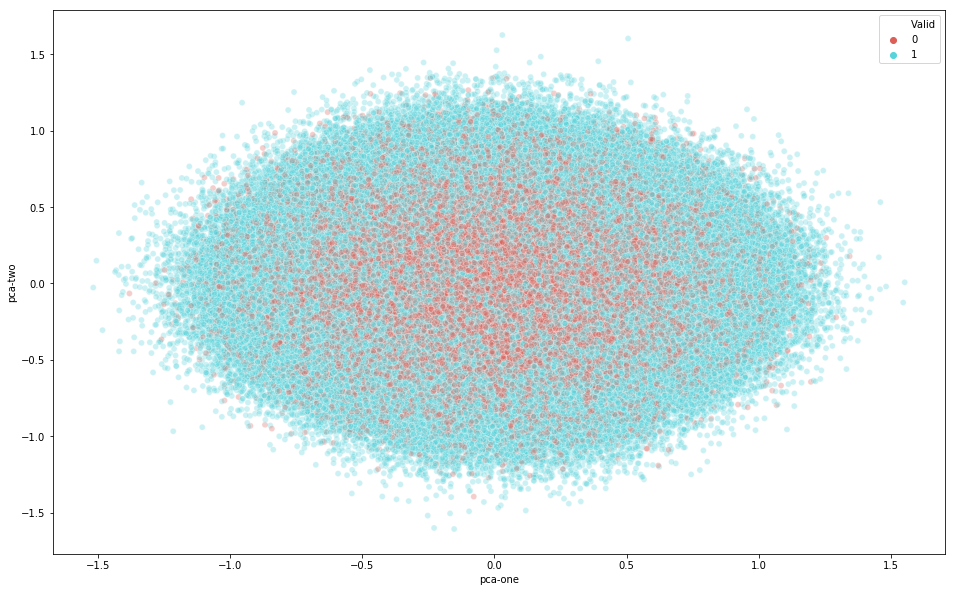

In [36]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="Valid",
    palette=sns.color_palette("hls", 2),
    data=df,
    legend="full",
    alpha=0.3
)

From the graph, we can see the invalid and valid sudokus do not look separable. Luckily there is another technique that we can use to reduce the number of dimensions that may prove more helpful. This technique is known as t-SNE (t-Distributed Stochastic Neighbouring Entities).

### t-Distributed Stochastic Neighbouring Entities (t-SNE)

"Since t-SNE scales quadratically in the number of objects N, its applicability,is limited to data sets with only a few thousand input objects." Hence, we will use only the first 10,000 samples to run the algorithm on.

In [37]:
from sklearn.manifold import TSNE
import time

N = 10000 # number of samples to run t-SNE on
X_subset = X.reshape(len(X), 81)[:N]

time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(X_subset)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.030s...
[t-SNE] Computed neighbors for 10000 samples in 18.629s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.632267
[t-SNE] KL divergence after 50 iterations with early exaggeration: 92.954712
[t-SNE] KL divergence after 300 iterations: 4.779155
t-SNE done! Time elapsed:

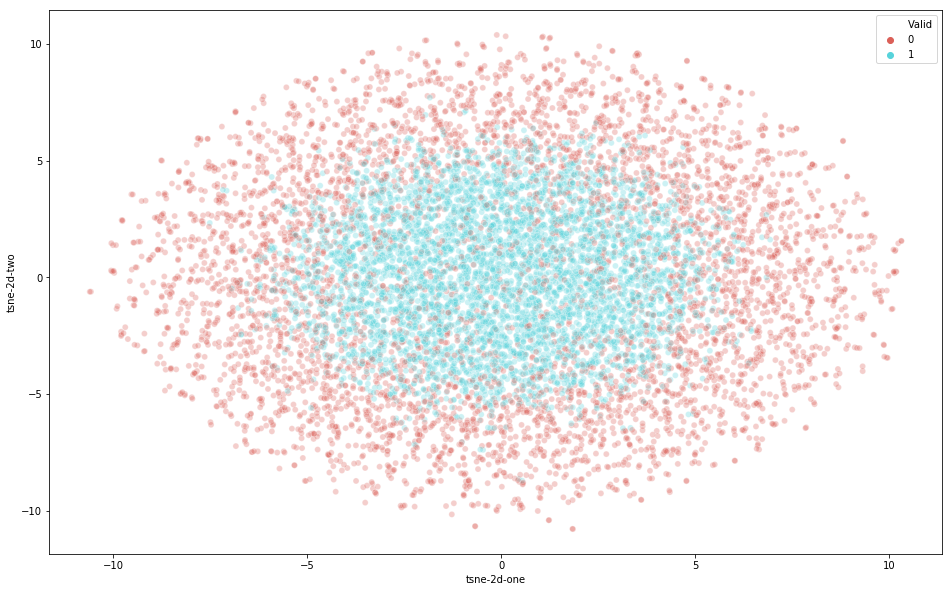

In [38]:
df_subset = df[:N].copy()
df_subset['tsne-2d-one'] = tsne_results[:,0]
df_subset['tsne-2d-two'] = tsne_results[:,1]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="Valid",
    palette=sns.color_palette("hls", 2),
    data=df_subset,
    legend="full",
    alpha=0.3
)

Hence, we can see that only the column weights are learnt. While this may help in detecting single errors in the sudoku (as the column sum will not be 45), it will not be useful in cases where the errors are such that the net sum across a column is 45. We conclude that this problem might not be solvable using our current setup, as the distributions are not clearly separable.

